notebook 05a produced this figure originally but we decided best to hierarchically cluster all DE genes from both Excit and CIN together to make cross-cell-type comparisions better

In [1]:
# Built-in
import os
import math
import itertools
import multiprocessing
import statistics

# Analysis packages
import scanpy as sc
import anndata as ad
from adpbulk import ADPBulk
import numpy as np
import pandas as pd
import memento
from statsmodels.compat import lzip
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as scipystats
from sklearn.decomposition import PCA
from sklearn import manifold
import sklearn.cluster as clustering
from tslearn.clustering import KShape
import h5py

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.patheffects as path_effects
from pathlib import Path
import seaborn as sns
from adjustText import adjust_text

# Set number of cores to use
sc.settings.n_jobs = 8

sc.logging.print_header()

scanpy==1.10.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.0 scipy==1.13.1 pandas==1.5.3 scikit-learn==1.5.0 statsmodels==0.13.5 igraph==0.11.6 pynndescent==0.5.8


In [2]:
pd.set_option('display.max_columns', 40)

In [3]:
# Set autoreload settings. With this code,
# changing settings.py (see next cell) automatically loads the new settings in here too.
%load_ext autoreload
%autoreload 1

# Modify settings from this file (figure path, subsetting settings, etc)
# The file is located in this directory (settings.py)
%aimport settings

# Overhead

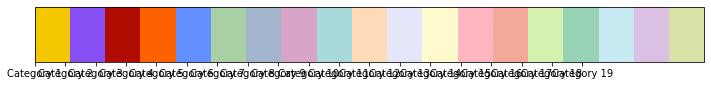

In [4]:
# Define the extended color list
colors_19 = [
    "#F4C700", "#8650F5", "#B00B00", "#FE6100", "#648FFF",
    "#A9CFA4", "#A3B5CC", "#D8A4C7", "#A8DADC", "#FFDAB9",
    "#E6E6FA", "#FFFACD", "#FFB6C1", "#F4A89A", "#D4F1B0",
    "#98D2B5", "#C7EAF2", "#DAC0E2", "#D9E3A8",
]

# Create a ListedColormap
custom_cmap = ListedColormap(colors_19)

# Display the colormap using a colorbar
fig, ax = plt.subplots(figsize=(12, 2))
fig.subplots_adjust(bottom=0.5)

# Create a colorbar with the custom cmap
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=custom_cmap), 
    cax=ax, orientation='horizontal', ticks=[]
)

# Use the colors as category labels
cbar.set_ticks([i / 22.0 for i in range(len(colors_19))])
cbar.set_ticklabels([f'Category {i + 1}' for i in range(len(colors_19))])

# Display the colorbar
plt.show()

In [46]:
grouped_colors = colors_19[0:3]
grouped_color_order = ['PT', 'IT', 'CIN']

In [5]:
cluster_colors = colors_19[0:5]
color_order = ['L5-PT','IT','CIN-PV','CIN-SST','CIN-VIP']

In [6]:
def extend_limits(t, buffer=0.02):
    lower = t[0]
    upper = t[1]
    extension = buffer * (upper - lower)
    return (lower - extension, upper + extension)
extend_limits((0,2))

(-0.04, 2.04)

In [7]:
adata = sc.read("post-wt-clustering-with-markers.h5ad")
adata

AnnData object with n_obs × n_vars = 264420 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden', 'id', 'name', 'color'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden', 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'name_colors', 'rank_genes_groups', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'
    obsp: 'connectivities', 'distances'

In [8]:
dendro_ordered_cluster_ids = adata.uns['dendrogram_leiden']['categories_ordered']

In [9]:
drugs = ["none", "Ket", "Psilo"]
times = adata.uns["stage_order"]
clusters = ['0','1','2','3','4','5','6','7','8','9','10','12']
cluster_names = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT',
                 'Oligodendrocytes','L5/6-IT','Astrocytes','L5-PT','CIN-PV',
                 'OPC','CIN-SST','CIN-VIP']

In [10]:
lump_excitatory = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT','L5/6-IT','L5-PT']
lump_cin = ['CIN-PV','CIN-SST','CIN-VIP']

In [11]:
trt_drugs = drugs[1:]
trt_times = times[1:]

In [12]:
cluster_lookup = pd.DataFrame({'id':clusters, 'name':cluster_names})
cluster_lookup['id'] = pd.Categorical(cluster_lookup['id'], categories=dendro_ordered_cluster_ids, ordered=True)
cluster_lookup = cluster_lookup.sort_values('id')
cluster_lookup['name'] = pd.Categorical(cluster_lookup['name'], categories=cluster_lookup['name'], ordered=True)
cluster_lookup['color'] = adata.uns['name_colors']
cluster_lookup

,id,name,color
1,1,L6-CT,#A9CFA4
7,7,L5-PT,#F4C700
2,2,L4/5-IT,#8650F5
3,3,L4-IT,#4F19BE
0,0,L2/3-IT,#7662A0
5,5,L5/6-IT,#BA98FF
11,12,CIN-VIP,#648FFF
8,8,CIN-PV,#B00B00
10,10,CIN-SST,#FE6100
4,4,Oligodendrocytes,#A3B5CC


In [13]:
heatmap_idx = cluster_lookup['name'].to_list()
heatmap_cluster_labels = cluster_lookup.apply(lambda row: f"({row['id']}) {row['name']}", axis=1).to_list()

In [41]:
this_figure_dir = f'{settings.fig_path}/figure_7_pseudobulk'
os.makedirs(this_figure_dir, exist_ok=True)

# Gather pseudobulk data

In [15]:
trt_times, trt_drugs

(array([ 1,  2,  4, 24, 72]), ['Ket', 'Psilo'])

In [21]:
PT_results = []
for time, drug in itertools.product(trt_times, trt_drugs):
    deg_results = pd.read_csv(os.path.join(settings.fig_path, 
                             f'figure_3/pseudobulk_clusters_counts/DEGs_{time}h_{drug}.csv'))
    sig_results = deg_results[deg_results['FDR'] < 0.05].copy()
    sig_results['time'] = time
    sig_results['drug'] = drug
    sig_results['celltype'] = 'PT'
    PT_results.append(sig_results)
    
PT_results = pd.concat(PT_results)

In [22]:
IT_results = []
for time, drug in itertools.product(trt_times, trt_drugs):
    deg_results = pd.read_csv(os.path.join(settings.fig_path, 
                             f'figure_4/pseudobulk_clusters_counts/DEGs_{time}h_{drug}.csv'))
    sig_results = deg_results[deg_results['FDR'] < 0.05].copy()
    sig_results['time'] = time
    sig_results['drug'] = drug
    sig_results['celltype'] = 'IT'
    IT_results.append(sig_results)
    
IT_results = pd.concat(IT_results)

In [25]:
CIN_results = []
for time, drug in itertools.product(trt_times, trt_drugs):
    deg_results = pd.read_csv(os.path.join(settings.fig_path, 
                             f'figure_5/pseudobulk_clusters_counts/DEGs_CIN_{time}h_{drug}.csv'))
    sig_results = deg_results[deg_results['FDR'] < 0.05].copy()
    sig_results['time'] = time
    sig_results['drug'] = drug
    sig_results['celltype'] = 'CIN'
    CIN_results.append(sig_results)
    
CIN_results = pd.concat(CIN_results)

In [38]:
pseudobulk_results = pd.concat([PT_results, IT_results, CIN_results])
pseudobulk_results = pseudobulk_results.drop("Unnamed: 0", axis=1)
pb_copy = pseudobulk_results.copy()
pseudobulk_results = {}
# for name, group in pseudobulk_results_groups:
for drug, time, celltype in itertools.product(trt_drugs, trt_times, ['PT','IT','CIN']):
    thing = pb_copy[(pb_copy['drug'] == drug) &
                                       (pb_copy['time'] == time) &
                                       (pb_copy['celltype'] == celltype)]
    pseudobulk_results[drug,time,celltype] = thing.sort_values('FDR', ascending=True).reset_index()
    
del pb_copy
pseudobulk_results['Psilo',1,'PT']

,index,logFC,logCPM,LR,PValue,ctrl.logCPM,cKO.logCPM,gene_name,FDR,time,drug,celltype
0,0,-1.261840,5.334446,54.317854,1.705452e-13,5.564965,4.332361,Coq10b,2.338687e-09,1,Psilo,PT
1,1,0.834914,7.001861,51.748880,6.307279e-13,6.714294,7.553997,Lyst,3.498436e-09,1,Psilo,PT
2,2,0.845340,7.428300,51.369056,7.653547e-13,7.135461,7.984226,Cop1,3.498436e-09,1,Psilo,PT
3,3,2.354544,3.460013,50.360874,1.279193e-12,2.207548,4.628963,AC163685.1,4.385395e-09,1,Psilo,PT
4,4,0.683456,7.285308,47.430143,5.699943e-12,7.061059,7.745355,Map4k3,1.563266e-08,1,Psilo,PT
...,...,...,...,...,...,...,...,...,...,...,...,...
1693,1693,-0.537762,3.727613,7.502071,6.162809e-03,3.841264,3.329736,Dnajb12,4.988456e-02,1,Psilo,PT
1694,1694,-0.877977,2.573374,7.501139,6.165998e-03,2.736532,1.812805,Gm13427,4.988456e-02,1,Psilo,PT
1695,1695,-0.251670,7.709314,7.498078,6.176486e-03,7.771599,7.522569,Gm4258,4.993995e-02,1,Psilo,PT
1696,1696,0.321815,8.713042,7.496698,6.181222e-03,8.609635,8.933148,Fras1,4.994028e-02,1,Psilo,PT


In [39]:
def cosine_similarity(A, B, value_column='logFC'):
    A_df = A[['gene_name', value_column]]
    B_df = B[['gene_name', value_column]]
    union_folds = A_df.merge(B_df, on='gene_name', how='outer').fillna(0)
    A_folds = union_folds[f'{value_column}_x'].to_numpy()
    B_folds = union_folds[f'{value_column}_y'].to_numpy()
    return np.dot(A_folds, B_folds) / (np.linalg.norm(A_folds) * np.linalg.norm(B_folds))

In [40]:
%%time

interdrug_dict = {tup:{} for tup in list(itertools.product(trt_times, ['PT','IT','CIN']))}

# for key, data in itertools.islice(interdrug_dict.items(), 3):
for key, data in interdrug_dict.items():
    sig_psilo_set = pseudobulk_results['Psilo', key[0], key[1]]
    sig_ket_set = pseudobulk_results['Ket', key[0], key[1]]
        
    data['num_psilo_DE'] = sig_psilo_set.shape[0]
    data['num_ket_DE'] = sig_ket_set.shape[0]
    data['num_shared_DE'] = sig_psilo_set.merge(sig_ket_set, how='inner', on='gene_name').shape[0]
    data['similarity'] = cosine_similarity(sig_psilo_set, sig_ket_set)

CPU times: user 85.3 ms, sys: 3.89 ms, total: 89.2 ms
Wall time: 88.9 ms


/tmp/ipykernel_3146715/1391136982.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(A_folds, B_folds) / (np.linalg.norm(A_folds) * np.linalg.norm(B_folds))
/tmp/ipykernel_3146715/1391136982.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(A_folds, B_folds) / (np.linalg.norm(A_folds) * np.linalg.norm(B_folds))


In [42]:
interdrug_list = [
    {'time':key[0], 'celltype':key[1], 
     'num_psilo_DE':data['num_psilo_DE'], 'num_ket_DE':data['num_ket_DE'], 
     'num_shared_DE':data['num_shared_DE'], 
     'similarity':data['similarity']}
    for key,data in interdrug_dict.items()
]
interdrug_df = pd.DataFrame(interdrug_list)
interdrug_df.to_csv(os.path.join(this_figure_dir, 'interdrug_similarity_comprehensive_data.csv'))
interdrug_df.head()

,time,celltype,num_psilo_DE,num_ket_DE,num_shared_DE,similarity
0,1,PT,1698,25,21,0.103690
1,1,IT,3401,59,45,0.111269
2,1,CIN,2222,4,4,0.073586
3,2,PT,108,331,76,0.364300
4,2,IT,84,711,71,0.295174


In [44]:
interdrug_df['psilo_fraction'] = interdrug_df['num_shared_DE'] / interdrug_df['num_psilo_DE']
interdrug_df['ket_fraction'] = interdrug_df['num_shared_DE'] / interdrug_df['num_ket_DE']
interdrug_df['one'] = 1.0
interdrug_df.isna().sum()

time              0
celltype          0
num_psilo_DE      0
num_ket_DE        0
num_shared_DE     0
similarity        2
psilo_fraction    0
ket_fraction      2
one               0
dtype: int64

In [45]:
def myround(x, base=5):
    return base * round(x/base)

# Plot

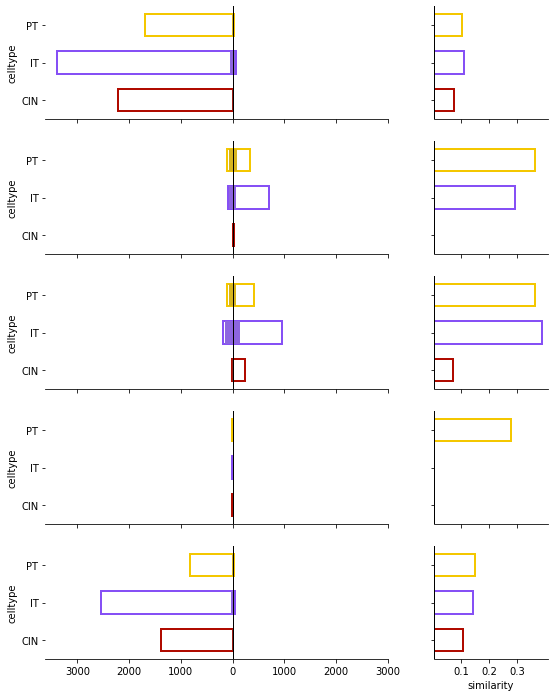

In [53]:
def plot_axis(data, axes_row):
    BAR_WIDTH = 0.6
    LINE_WIDTH = 2.0
    sns.barplot(
        data=data,
        x='num_ket_DE', y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    sns.barplot(
        data=data,
        x = -data['num_psilo_DE'], y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )

    sns.barplot(
        data=data,
        x='num_shared_DE', y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    sns.barplot(
        data=data,
        x= -data['num_shared_DE'], y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    
    sns.barplot(
        data=data,
        x='similarity', y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[1],
    )
    
gs_kw = dict(width_ratios=[3,1],)    
fig, axes = plt.subplots(5, 2, figsize=(9,12), gridspec_kw=gs_kw,
                        sharey='row', sharex='col')
fig.set_facecolor('white')

sns.despine(fig=fig, top=True, right=True, left=True, bottom=False)
for ax in axes.flatten():
    ax.set_xticks([])
    ax.axvline(0, linestyle='-', color='black', linewidth=1)

    for ax_index, time in enumerate(trt_times):
        plot_axis(interdrug_df.query(f'time == {time}'), axes[ax_index])

max_de_size = interdrug_df[['num_psilo_DE','num_ket_DE']].max().max()
de_size_ticks = np.arange(myround(-max_de_size, base=1000), myround(max_de_size, base=1000)+1, 1000)
axes[-1][0].set_xticks(de_size_ticks, labels=np.abs(de_size_ticks))
axes[-1][-1].set_xticks(np.arange(0.1, interdrug_df['similarity'].max(), 0.1))

fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive.png")
fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive.pdf")

## fractions of gene counts

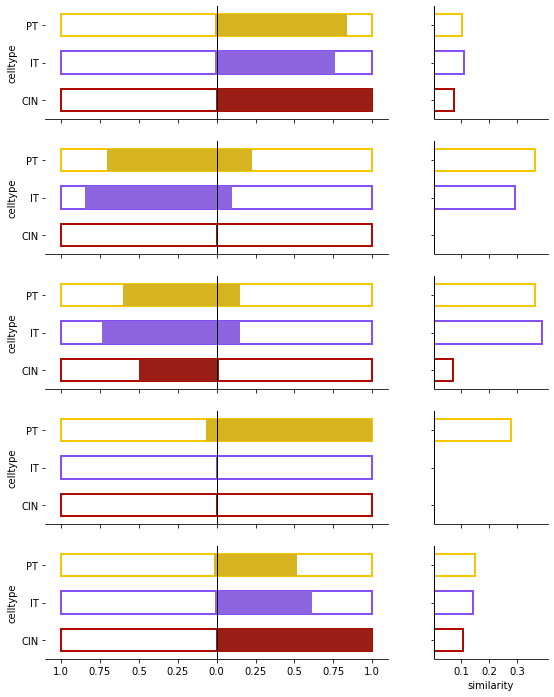

In [56]:
def plot_axis(data, axes_row):
    BAR_WIDTH = 0.6
    LINE_WIDTH = 2.0
    sns.barplot(
        data=data,
        x='one', y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    sns.barplot(
        data=data,
        x = -data['one'], y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )

    sns.barplot(
        data=data,
        x='ket_fraction', y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    sns.barplot(
        data=data,
        x= -data['psilo_fraction'], y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    
    sns.barplot(
        data=data,
        x='similarity', y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[1],
    )
    
gs_kw = dict(width_ratios=[3,1],)    
fig, axes = plt.subplots(5, 2, figsize=(9,12), gridspec_kw=gs_kw,
                        sharey='row', sharex='col')
fig.set_facecolor('white')

sns.despine(fig=fig, top=True, right=True, left=True, bottom=False)
for ax in axes.flatten():
    ax.set_xticks([])
    ax.axvline(0, linestyle='-', color='black', linewidth=1)

    for ax_index, time in enumerate(trt_times):
        plot_axis(interdrug_df.query(f'time == {time}'), axes[ax_index])

frac_max = 1.0
de_frac_ticks = np.linspace(-frac_max, frac_max, 9)
axes[-1][0].set_xticks(de_frac_ticks, labels=np.abs(de_frac_ticks))
axes[-1][-1].set_xticks(np.arange(0.1, interdrug_df['similarity'].max(), 0.1))

# max_de_size = interdrug_df[['num_psilo_DE','num_ket_DE']].max().max()
# de_size_ticks = np.arange(myround(-max_de_size, base=1000), myround(max_de_size, base=1000)+1, 1000)
# axes[-1][0].set_xticks(de_size_ticks, labels=np.abs(de_size_ticks))
# axes[-1][-1].set_xticks(np.arange(0.1, interdrug_df['similarity'].max(), 0.1))

fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive_fractions.png")
fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive_fractions.pdf")

## Whitespace between drugs, fill cosine sim bar

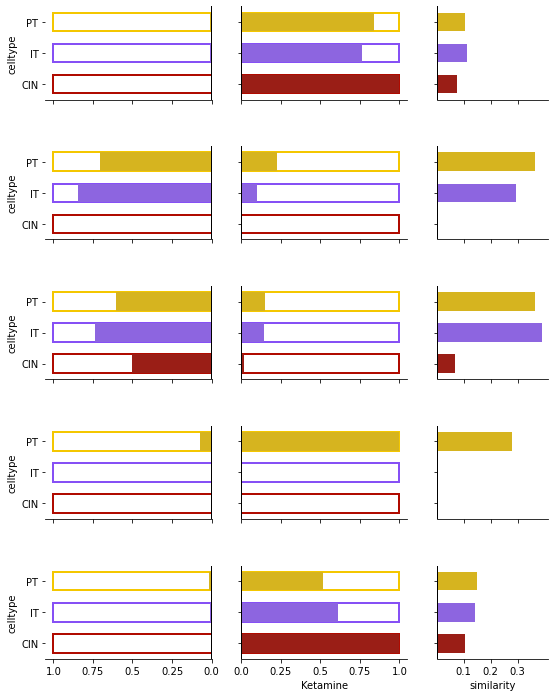

In [64]:
def plot_axis(data, axes_row):
    BAR_WIDTH = 0.6
    LINE_WIDTH = 2.0
    sns.barplot(
        data=data,
        x='one', y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[1],
    )
    sns.barplot(
        data=data,
        x = -data['one'], y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )

    sns.barplot(
        data=data,
        x='ket_fraction', y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[1],
    )
    sns.barplot(
        data=data,
        x= -data['psilo_fraction'], y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    
    sns.barplot(
        data=data,
        x='similarity', y='celltype', hue='celltype',
        palette=grouped_colors, hue_order=grouped_color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[-1],
    )
    
gs_kw = dict(width_ratios=[1.5, 1.5, 1], hspace=0.5)    
fig, axes = plt.subplots(5, 3, figsize=(9,12), gridspec_kw=gs_kw,
                        sharey='row', sharex='col')
fig.set_facecolor('white')

sns.despine(fig=fig, top=True, right=True, left=True, bottom=False)
for ax in axes.flatten():
    ax.set_xticks([])
    ax.axvline(0, linestyle='-', color='black', linewidth=2)

    for ax_index, time in enumerate(trt_times):
        plot_axis(interdrug_df.query(f'time == {time}'), axes[ax_index])

frac_max = 1.0
de_frac_ticks = np.linspace(0.0, frac_max, 5)
axes[-1][0].set_xticks(-de_frac_ticks, labels=np.abs(de_frac_ticks))
axes[-1][1].set_xticks(de_frac_ticks, labels=np.abs(de_frac_ticks))
axes[-1][-1].set_xticks(np.arange(0.1, interdrug_df['similarity'].max(), 0.1))

# max_de_size = interdrug_df[['num_psilo_DE','num_ket_DE']].max().max()
# de_size_ticks = np.arange(myround(-max_de_size, base=1000), myround(max_de_size, base=1000)+1, 1000)
# axes[-1][0].set_xticks(de_size_ticks, labels=np.abs(de_size_ticks))
# axes[-1][-1].set_xticks(np.arange(0.1, interdrug_df['similarity'].max(), 0.1))

axes[-1][0].set_xlabel('Psilocybin')
axes[-1][1].set_xlabel('Ketamine')

fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive_fractions_gap.png")
fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive_fractions_gap.pdf")